# DDPM Example (Denoising Diffusion Probabilistic Model)

### DDPM Paper : https://hojonathanho.github.io/diffusion/

![DDPM Training and Sampling](assets/ddpm_training_sampling.png)

# Import useful libraries

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

2024-01-17 07:10:27.106113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 07:10:28.260214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-01-17 07:10:28.260328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or director

In [2]:
print("OpenCV version: ", cv2.__version__)
print ("TF Version: ", tf.__version__)

OpenCV version:  4.9.0
TF Version:  2.11.0


# Download and show Data

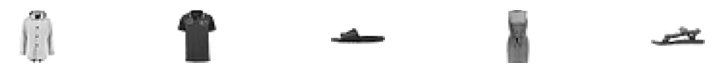

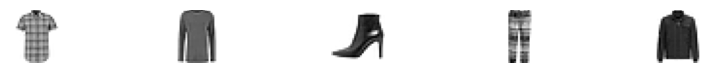

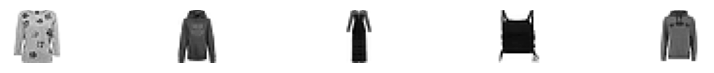

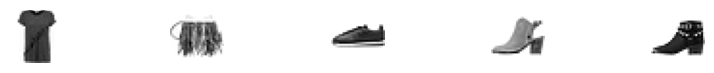

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
for k in range(4):
    plt.figure(figsize=(10, 4))
    for j in range(5):
        i = np.random.randint(0, 10000)
        plt.subplot(550 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

# Config (HyperParameters for diffusion model setup)

In [4]:
# model related
batch_size=64
epochs=20
max_timesteps=1000
residual_blocks=2
first_conv_layer_width = fclw = 64
network_widths=[fclw * 1, fclw * 2, fclw * 4, fclw * 8]
has_attention = [False, False, True, True]
norm_groups=8
learning_rate=0.0004

# dataset related
img_size=32
img_channels=1

# Data Preparation

### Data preparation and augmentation utility functions

In [5]:
def preprocess_image(img, size):
    """Resize and Scale images."""
    height, width = tf.shape(img)[0], tf.shape(img)[1]

    # resizing
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size, antialias=True)

    # scaling to [-1, 1]
    img = (img/127.5) - 1.0
    img = tf.clip_by_value(img, -1.0, 1.0)
    return img

In [6]:
def flip_image(img):
    """flipping image horizontally."""
    img = cv2.flip(img, 1)
    return img

### loading and preparing data for the model

#### Fashion MNIST

In [7]:
(dataset,) = tfds.load(
    "fashion_mnist",
    split=['train'],
    with_info=False,
    shuffle_files=True,
)

2024-01-17 07:10:46.920361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 07:10:46.952319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 07:10:46.952658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 07:10:46.953485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
def prepare_data(x):
    img = x['image']
    img = preprocess_image(img, size=(img_size, img_size))
    return img

#### Creating training dataset

In [9]:
train_ds = (
    dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

# Utility functions for Diffusion 

In [10]:
class DiffusionUtils:
    """Utility functions for diffusion."""
    def __init__(
        self,
        beta_start=0.0001,
        beta_end=0.02,
        timesteps=100,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        
        # linear variance schedule
        self.beta_list = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype = np.float64, # high precision
        )
        
        # alpha calculations
        self.alpha_list = 1.0 - self.beta_list
        self.alpha_list_sqrt = np.sqrt(self.alpha_list)
        self.alpha_cumprod = np.cumprod(self.alpha_list, axis=0)
        self.alpha_cumprod_prev = np.append(1.0, self.alpha_cumprod[:-1])
        
        # calculations as per diffusion equations: q(X{t} | X{t-1})
        self.alpha_cumprod_sqrt = np.sqrt(self.alpha_cumprod)
        self.one_minus_alpha_cumprod_sqrt = np.sqrt(1.0 - self.alpha_cumprod)
        self.log_one_minus_alpha_cumprod = np.log(1.0 - self.alpha_cumprod)
        self.alpha_cumprod_recip_sqrt = np.sqrt(1.0 / self.alpha_cumprod)
        self.alpha_cumprod_recip_minus_one_sqrt = np.sqrt(
            1.0 / self.alpha_cumprod - 1
        )
        
        # calculations for posterior: q(X{t-1} | X{t}, X{0})
        self.posterior_variance = (
            self.beta_list * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        )
        # taking maximum here to avoid zero at beginning
        self.posterior_log_variance = np.log(
            np.maximum(self.posterior_variance, 1e-20)
        )
        self.posterior_coef1 = (
            self.beta_list * np.sqrt(self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        )
        self.posterior_coef2 = (
            (1.0 - self.alpha_cumprod_prev) * self.alpha_list_sqrt / (1.0 - self.alpha_cumprod)
        )


    def get_coefficients(self, values, timestep, batch_size):
        """extract coefficients for given timestep from defined values."""
        # converting defined_values array to tensor
        tensor = tf.constant(values, dtype=tf.float32)
        output = tf.gather(tensor, timestep)
        # reshaping for broadcasting purpose
        output = tf.reshape(
            output, [batch_size, 1, 1, 1]
        )
        return output

    def q_mean_and_variance(self, x_zero, timestep):
        """calculates mean and variance at given timestep.

        Here x_zero is initial sample.
        """
        x_zero_shape = tf.shape(x_zero)
        mean = self.get_coefficients(
            self.alpha_cumprod_sqrt, timestep, x_zero_shape[0]
        ) * x_zero
        variance = self.get_coefficients(
            1.0 - self.alpha_cumprod, timestep, x_zero_shape[0]
        )
        log_variance = self.get_coefficients(
            self.log_one_minus_alpha_cumprod, timestep, x_zero_shape[0]
        )
        return mean, variance, log_variance

    def q_sample(self, x_zero, timestep, noise):
        """add noise to the sample wrt. timestep."""
        x_zero_shape = tf.shape(x_zero)
        noisy = self.get_coefficients(
            self.alpha_cumprod_sqrt, timestep, x_zero_shape[0]
        ) * x_zero + self.get_coefficients(
            self.one_minus_alpha_cumprod_sqrt, timestep, x_zero_shape[0]
        ) * noise
        return noisy

    def predict_from_noise(self, x_t, timestep, noise):
        """predict start from the noise."""
        batch_size = tf.shape(x_t)[0]
        output = self.get_coefficients(
            self.alpha_cumprod_recip_sqrt, timestep, batch_size
        ) * x_t - self.get_coefficients(
            self.alpha_cumprod_recip_minus_one_sqrt, timestep, batch_size
        ) * noise
        return output

    def q_posterior_mean_variance(self, x_zero, x_t, timestep):
        """return posterior mean and variance at current timestep."""
        batch_size = tf.shape(x_t)[0]
        posterior_mean = self.get_coefficients(
            self.posterior_coef1, timestep, batch_size
        ) * x_zero + self.get_coefficients(
            self.posterior_coef2, timestep, batch_size
        ) * x_t
        posterior_variance = self.get_coefficients(
            self.posterior_variance, timestep, batch_size
        )
        posterior_log_variance = self.get_coefficients(
            self.posterior_log_variance, timestep, batch_size
        )
        return posterior_mean, posterior_variance, posterior_log_variance

    def p_mean_variance(self, pred_noise, x, timestep, clip=True):
        """return mean and variance for predicted noise."""
        x_reconstructed = self.predict_from_noise(
            x, timestep, noise=pred_noise
        )
        if clip:
            x_reconstructed = tf.clip_by_value(
                x_reconstructed, -1.0, 1.0
            )
        model_mean, posterior_variance, posterior_log_variance = (
            self.q_posterior_mean_variance(
                x_zero=x_reconstructed, x_t=x, timestep=timestep
            )
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip=True):
        """Sampling from the diffusion model."""
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, timestep=t, clip=clip
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # only when t=0, there is no noise
        non_zero_mask = tf.reshape(
            1 - tf.cast(
                tf.equal(t, 0), tf.float32
            ), [tf.shape(x)[0], 1, 1, 1]
        )
        output = model_mean + non_zero_mask * tf.exp(
            0.5 * model_log_variance
        ) * noise
        return output

# Define Model (UNET)

### define kernel initializer

In [11]:
def get_kernel_initializer(scale):
    scale = max(scale, 1e-10) # avoid zero
    kernel_init = tf.keras.initializers.VarianceScaling(
        scale=scale, mode="fan_avg", distribution="uniform"
    )
    return kernel_init

### unet model building blocks

#### Timestep embedding layer

In [12]:
class TimeEmbedding(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

#### dense layer for timestep embedding

In [13]:
def get_dense_time_embedding(inputs, units, activation):
    x = tf.keras.layers.Dense(
        units,
        activation=activation,
        kernel_initializer=get_kernel_initializer(1.0),
    )(inputs)
    x = tf.keras.layers.Dense(
        units,
        kernel_initializer=get_kernel_initializer(1.0),
    )(x)
    return x

#### Residual UNET block

In [14]:
def residual_unet_block(
    data,
    width,
    attention,
    groups=8,
    activation=tf.keras.activations.swish,
):
    x, t = data
    if x.shape[3] == width:
        # if dimension same
        residual = x
    else:
        # make dimensions same for skip connection
        residual = tf.keras.layers.Conv2D(
            width,
            kernel_size=1,
            kernel_initializer=get_kernel_initializer(1.0),
        )(x)
    
    # time embedding features
    time_emb = activation(t)
    time_emb = tf.keras.layers.Dense(
        width,
        kernel_initializer=get_kernel_initializer(1.0),
    )(time_emb)[:, None, None, :]
    
    # regular Conv block
    x = tf.keras.layers.GroupNormalization(groups=groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(x)
    
    # adding time_embedding to x
    x = tf.keras.layers.Add()([x, time_emb])
    
    # Another Conv Block
    x = tf.keras.layers.GroupNormalization(groups=groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(0.0),
    )(x)
    
    # residual or skip-connection 
    x = tf.keras.layers.Add()([x, residual])

    # add attention layer
    if attention:
        residual = x
        x = tf.keras.layers.GroupNormalization(
            groups=groups,
            center=False,
            scale=False,
        )(x)
        # Multi Headed Self Attention layer
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=4,
            key_dim=width,
            attention_axes=(1, 2),
        )(x, x)
        # residual connection
        x = tf.keras.layers.Add()([residual, x])

    return x

#### downsampling block for UNET

In [15]:
def downsample_block(data, width):
    # Conv block with strides for downsampling
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        strides=2,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(data)
    return x

#### up-sampling block for UNET

In [16]:
def upsample_block(data, width, interpolation="nearest"):
    # using upsampling2D layer
    x = tf.keras.layers.UpSampling2D(
        size=2,
        interpolation=interpolation,
    )(data)
    x = tf.keras.layers.Conv2D(
        width,
        kernel_size=3,
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(x)
    return x

### build unet model

In [17]:
def build_unet(
    img_size, 
    img_channels,
    first_conv_layer_width,
    network_widths,
    has_attention,
    residual_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation=tf.keras.activations.swish,
):
    img_input = tf.keras.layers.Input(
        shape=(img_size, img_size, img_channels), name="input_img"
    )
    time_input = tf.keras.Input(shape=(), dtype=tf.int64, name="time")

    # first conv layer on img
    x = tf.keras.layers.Conv2D(
        first_conv_layer_width,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=get_kernel_initializer(1.0),
    )(img_input)

    # creating time embedding
    time_emb = TimeEmbedding(dim=first_conv_layer_width * 4)(time_input)
    time_emb = get_dense_time_embedding(
        inputs=time_emb,
        units=first_conv_layer_width * 4,
        activation=activation
    )
    
    # list for skip-connections
    skips = [x]
    
    # Encoder part of our UNET (Downsampling)
    for i in range(len(network_widths)):
        for _ in range(residual_blocks):
            x = residual_unet_block(
                [x, time_emb],
                network_widths[i],
                has_attention[i],
                groups=norm_groups,
                activation=activation,
            )            
            skips.append(x)
        
        if network_widths[i] != network_widths[-1]:
            # if not last block: Downsample
            x = downsample_block(x, network_widths[i])
            skips.append(x)
    
    # Middle Block of UNET with two residual blocks(Bottleneck)
    x = residual_unet_block(
        [x, time_emb],
        width=network_widths[-1],
        attention=True,
        groups=norm_groups,
        activation=activation,
    )
    x = residual_unet_block(
        [x, time_emb],
        width=network_widths[-1],
        attention=True,
        groups=norm_groups,
        activation=activation,
    )
    
    # Decoder part of our UNET (Upsampling)
    for i in reversed(range(len(network_widths))):
        for _ in range(residual_blocks+1):
            # add skip-connection UNET style
            x = tf.keras.layers.Concatenate(
                axis=-1
            )([x, skips.pop()])
            x = residual_unet_block(
                [x, time_emb],
                network_widths[i],
                has_attention[i],
                groups=norm_groups,
                activation=activation,
            )
            # add your attention block here
            
        if i != 0:
            # if not last block: Upsample
            x = upsample_block(
                data=x,
                width=network_widths[i],
                interpolation=interpolation,
            )
    
    # Final Block of UNET
    x = tf.keras.layers.GroupNormalization(groups=norm_groups)(x)
    x = activation(x)
    x = tf.keras.layers.Conv2D(
        img_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=get_kernel_initializer(0.0),
    )(x)
    
    unet_model = tf.keras.models.Model(
        inputs=[img_input, time_input],
        outputs=x,
        name="unet_network",
    )
    return unet_model

# Training Utility for our Diffusion Model

In [18]:
class DiffusionModel(tf.keras.Model):
    """Here we define utilities for training.
    
    And, plotting the generated data from model.
    """
    def __init__(
        self,
        img_size,
        img_channels,
        unet_network,
        ema_unet_network,
        timesteps,
        diffusion_utils,
        ema=0.999,
    ):
        super().__init__()
        self.img_size=img_size
        self.img_channels=img_channels
        self.unet_network = unet_network
        self.ema_unet_network = ema_unet_network
        self.timesteps = timesteps
        self.diffusion_utils = diffusion_utils
        self.ema = ema
        
    def train_step(self, img_batch):
        # retrieve the batch size
        batch_size = tf.shape(img_batch)[0]

        # sampling timestep (uniform)
        timestep = tf.random.uniform(
            minval=0,
            maxval=self.timesteps,
            shape=(batch_size, ),
            dtype=tf.int64,
        )
        
        with tf.GradientTape() as tape:
            # get random noise
            noise = tf.random.normal(
                shape=tf.shape(img_batch),
                dtype=img_batch.dtype,
            )
            
            # diffusing the images with noise
            img_batch_t = self.diffusion_utils.q_sample(
                img_batch,
                timestep,
                noise,
            )

            # predict the diffused noise using UNET
            pred_noise = self.unet_network(
                [img_batch_t, timestep],
                training=True
            )
            
            # calculate the model loss (L2 loss)
            loss = self.loss(noise, pred_noise)
        
        # fetch the gradients
        gradients = tape.gradient(
            loss,
            self.unet_network.trainable_weights
        )
        
        # updating the weights of the network (optimizer step)
        self.optimizer.apply_gradients(
            zip(gradients, self.unet_network.trainable_weights)
        )
        
        # updating the weights of the ema network
        for new_weight, ema_weight in zip(
            self.unet_network.weights,
            self.ema_unet_network.weights,
        ):
            ema_weight.assign(
                self.ema * ema_weight + (1 - self.ema) * new_weight
            )
        
        # return the loss value
        return {"loss": loss}

    # define a funtion to generate images from noise
    def generate_images(self, img_size, img_channels, num_images=8):
        # generate a batch of pure random noise
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels),
            dtype=tf.float32,
        )

        # sample from the model iteratively (for each timestep)
        for timestep in reversed(range(0, self.timesteps)):
            # assign timestep for each sample in the batch
            timestep_batch = tf.cast(
                tf.fill(num_images, timestep),
                dtype=tf.int64,
            )
            
            # predict noise using unet network at given timestep
            pred_noise = self.ema_unet_network.predict(
                [samples, timestep_batch],
                verbose=0,
                batch_size=num_images,
            )
            
            # sample from the diffusion model using predicted noise
            samples = self.diffusion_utils.p_sample(
                pred_noise,
                samples,
                timestep_batch,
                clip=True,
            )
        
        # return the generated samples
        return samples
    
    # a function to plot the generated images
    def plot_generated_images(
        self,
        epoch=None,
        logs=None,
        show=True,
        rows=1,
        cols=5,
        figsize=(5, 4),
    ):
        if not show:
            return
        
        # get image size
        img_size=self.img_size
        img_channels=self.img_channels

        # generate images using the diffusion model
        generated_images = self.generate_images(
            img_size=img_size,
            img_channels=img_channels,
            num_images=rows*cols,
        )

        # convert the pixel ranges of generated images to [0, 255]
        generated_images = (
            tf.clip_by_value(
                generated_images * 127.5 + 127.5, 0.0, 255.0
            ).numpy().astype(np.uint8)
        )
        
        # plotting images using matplotlib
        _, ax = plt.subplots(rows, cols, figsize=figsize)
        cmap=None
        if img_channels == 1:
            cmap="gray_r"
        for ix, image in enumerate(generated_images):
            if rows == 1:
                ax[ix].imshow(image, cmap=cmap)
                ax[ix].axis("off")
            else:
                ax[ix // cols, ix % cols].imshow(image, cmap=cmap)
                ax[ix // cols, ix % cols].axis("off")
        
        plt.tight_layout()
        plt.show()

# Build the Diffusion Model

In [19]:
# build UNET network
unet_network = build_unet(
    img_size=img_size,
    img_channels=img_channels,
    first_conv_layer_width=first_conv_layer_width,
    network_widths=network_widths,
    has_attention=has_attention,
    residual_blocks=residual_blocks,
    norm_groups=norm_groups,
)

# build similar UNET for storing EMA weights
ema_unet_network = build_unet(
    img_size=img_size,
    img_channels=img_channels,
    first_conv_layer_width=first_conv_layer_width,
    network_widths=network_widths,
    has_attention=has_attention,
    residual_blocks=residual_blocks,
    norm_groups=norm_groups,
)

# initially the weights of both networks should be same
ema_unet_network.set_weights(unet_network.get_weights())

# create an instance of diffusion utility class
diffusion_utils = DiffusionUtils(timesteps=max_timesteps)

# get final diffusion model with our custom training setup
diffusion_model = DiffusionModel(
    img_size=img_size,
    img_channels=img_channels,
    unet_network=unet_network,
    ema_unet_network=ema_unet_network,
    timesteps=max_timesteps,
    diffusion_utils=diffusion_utils,
)

# Compling the Diffusion model

In [20]:
diffusion_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    )
)

# Training Diffusion Model

Epoch 1/20


2024-01-17 07:12:07.358534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-01-17 07:12:09.018355: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7d6186dcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 07:12:09.018408: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-01-17 07:12:09.025472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 07:12:09.157596: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


937/937 [==============================] - ETA: 0s - loss: 0.1034

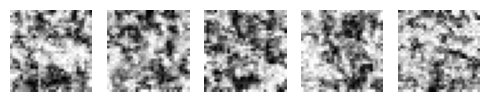

937/937 [==============================] - 327s 267ms/step - loss: 0.1033
Epoch 2/20
937/937 [==============================] - ETA: 0s - loss: 0.0316

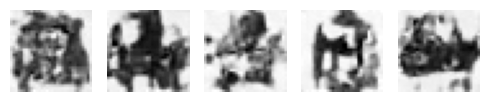

937/937 [==============================] - 243s 259ms/step - loss: 0.0316
Epoch 3/20
937/937 [==============================] - ETA: 0s - loss: 0.0287

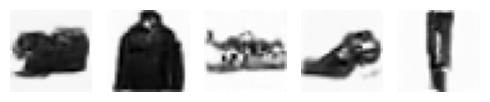

937/937 [==============================] - 244s 261ms/step - loss: 0.0288
Epoch 4/20
937/937 [==============================] - ETA: 0s - loss: 0.0273

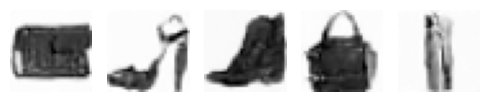

937/937 [==============================] - 243s 260ms/step - loss: 0.0273
Epoch 5/20
937/937 [==============================] - ETA: 0s - loss: 0.0270

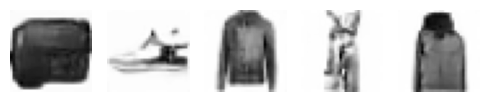

937/937 [==============================] - 243s 260ms/step - loss: 0.0270
Epoch 6/20
937/937 [==============================] - ETA: 0s - loss: 0.0263

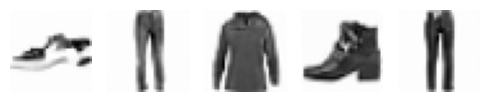

937/937 [==============================] - 249s 265ms/step - loss: 0.0263
Epoch 7/20
937/937 [==============================] - ETA: 0s - loss: 0.0257

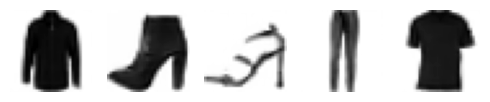

937/937 [==============================] - 241s 257ms/step - loss: 0.0257
Epoch 8/20
937/937 [==============================] - ETA: 0s - loss: 0.0258

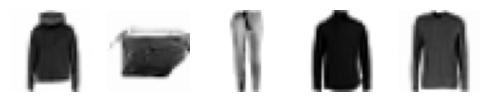

937/937 [==============================] - 245s 261ms/step - loss: 0.0258
Epoch 9/20
937/937 [==============================] - ETA: 0s - loss: 0.0253

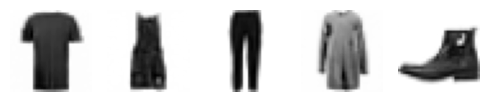

937/937 [==============================] - 246s 263ms/step - loss: 0.0253
Epoch 10/20
937/937 [==============================] - ETA: 0s - loss: 0.0250

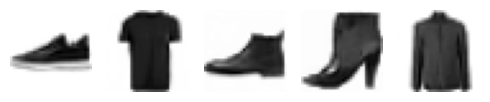

937/937 [==============================] - 244s 260ms/step - loss: 0.0250
Epoch 11/20
937/937 [==============================] - ETA: 0s - loss: 0.0247

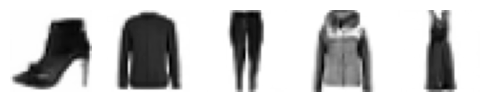

937/937 [==============================] - 246s 263ms/step - loss: 0.0248
Epoch 12/20
937/937 [==============================] - ETA: 0s - loss: 0.0247

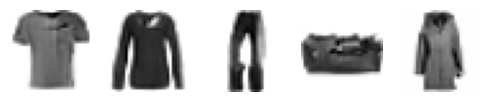

937/937 [==============================] - 244s 260ms/step - loss: 0.0247
Epoch 13/20
937/937 [==============================] - ETA: 0s - loss: 0.0251

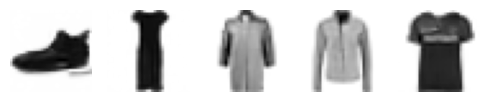

937/937 [==============================] - 246s 263ms/step - loss: 0.0251
Epoch 14/20
937/937 [==============================] - ETA: 0s - loss: 0.0245

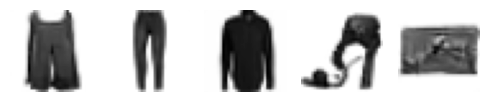

937/937 [==============================] - 245s 261ms/step - loss: 0.0245
Epoch 15/20
937/937 [==============================] - ETA: 0s - loss: 0.0247

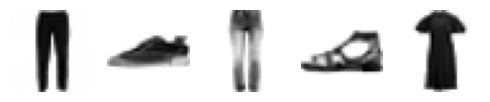

937/937 [==============================] - 244s 260ms/step - loss: 0.0247
Epoch 16/20
937/937 [==============================] - ETA: 0s - loss: 0.0246

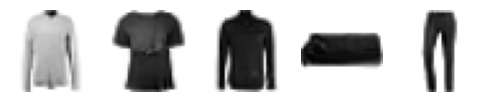

937/937 [==============================] - 246s 262ms/step - loss: 0.0246
Epoch 17/20
937/937 [==============================] - ETA: 0s - loss: 0.0245

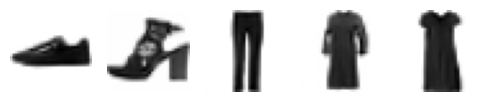

937/937 [==============================] - 244s 260ms/step - loss: 0.0245
Epoch 18/20
937/937 [==============================] - ETA: 0s - loss: 0.0241

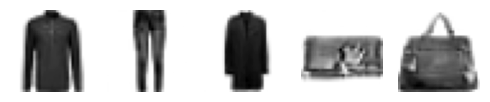

937/937 [==============================] - 246s 263ms/step - loss: 0.0241
Epoch 19/20
937/937 [==============================] - ETA: 0s - loss: 0.0246

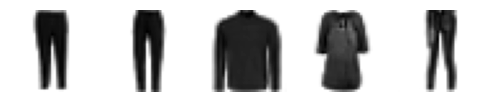

937/937 [==============================] - 246s 262ms/step - loss: 0.0246
Epoch 20/20
937/937 [==============================] - ETA: 0s - loss: 0.0247

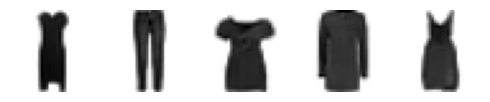

937/937 [==============================] - 242s 258ms/step - loss: 0.0247


In [21]:
diffusion_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_end=diffusion_model.plot_generated_images
    )],
)

# Generating Samples from Diffusion Model

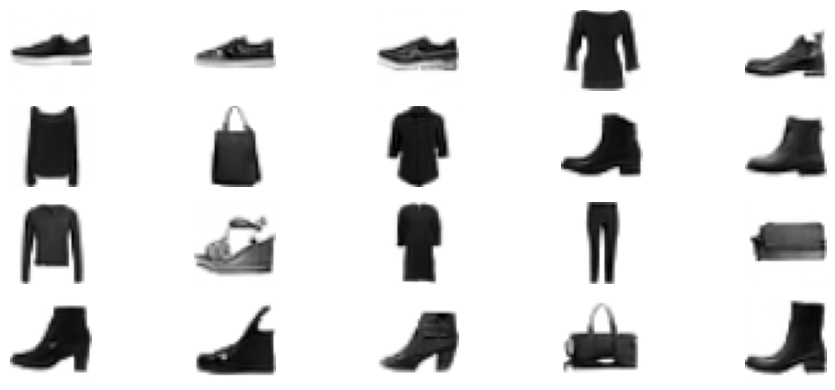

In [25]:
diffusion_model.plot_generated_images(show=True, rows=4, cols=5, figsize=(10,4))

# Loss chart

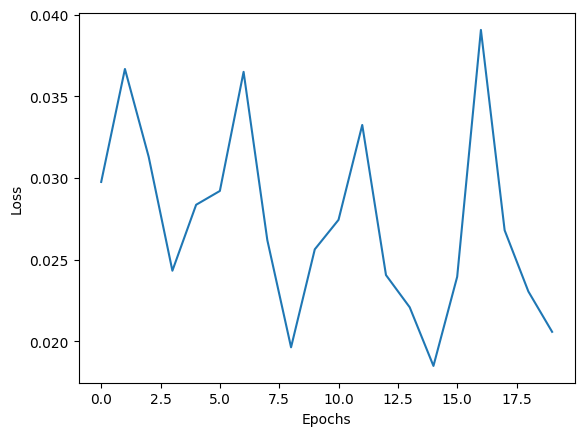

In [23]:
plt.plot(diffusion_model.history.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

# Network Summary

In [24]:
unet_network.summary()

Model: "unet_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 time_embedding (TimeEmbedding)  (None, 256)         0           ['time[0][0]']                   
                                                                                                  
 input_img (InputLayer)         [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          65792       ['time_embedding[0][0]']         
                                                                                       